# 젠더 법안 K-means

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
from krwordrank.hangle import normalize
%matplotlib inline

In [3]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [4]:
gender = pd.read_csv('./19th-gender-bill.csv', 
                      index_col=0, parse_dates=['제안일자','의결일자'] )
gender = gender.drop('level_0',1)
print(gender.shape)

(1044, 10)


In [5]:
gender.head()

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,1918726,유아교육법 일부개정법률안,2016-05-18,위원장,2016-05-19,원안가결,제19대 (2012~2016) 제342회,1. 최근 보육기관에서 아동학대 사건이 잇달아 발생하고 있는 가운데 아동학대 ...,교육문화체육관광위원회,[]
1,1918721,초·중등교육법 일부개정법률안,2016-05-18,위원장,2016-05-19,원안가결,제19대 (2012~2016) 제342회,"1. 학교운영위원회 위원의 결격사유를 강화하고, 법정형을 정비하려는 것임.2....",교육문화체육관광위원회,[]
2,1918710,건강가정기본법 일부개정법률안,2016-05-18,위원장,2016-05-19,원안가결,제19대 (2012~2016) 제342회,"1. 국가와 지방자치단체의 모성보호 및 부성보호의 책임을 명시하고, 육아휴직 ...",여성가족위원회,[]
3,1918709,아동·청소년의 성보호에 관한 법률 일부개정법률안,2016-05-18,위원장,2016-05-19,원안가결,제19대 (2012~2016) 제342회,1. 성범죄자 재범방지교육의 효과성 평가를 위하여 교육 이수자에 대한 재범률 ...,여성가족위원회,[]
4,1918705,주민등록법 일부개정법률안,2016-05-18,위원장,2016-05-19,원안가결,제19대 (2012~2016) 제342회,1. 주민등록번호의 유출로 인하여 발생할 수 있는 피해에 대한 국민의 불안감이...,안전행정위원회,[]


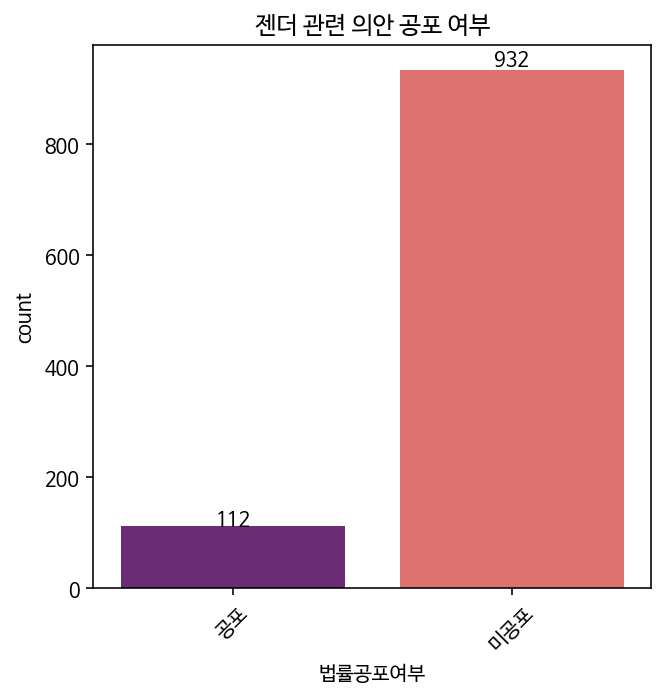

In [6]:
def proornot_vis(df, name): 
    plt.figure(figsize = (5,5))
    plt.xticks(rotation = 45)
    ax = sns.countplot(x = '법률공포여부', data = df, 
              palette = 'magma')

    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')

    plt.title(f'{name} 관련 의안 공포 여부')
    plt.show()

proclaim_list = ['원안가결', '수정가결']
reject_list = ['임기만료폐기', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기','계류']

gender.loc[gender['의결결과'].isin(proclaim_list), '법률공포여부'] = '공포'
gender.loc[gender['의결결과'].isin(reject_list), '법률공포여부'] = '미공포'

proornot_vis(gender, '젠더')

In [4]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [5]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [6]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 75.6 ms, sys: 3.18 ms, total: 78.8 ms
Wall time: 81.2 ms


In [7]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [8]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 52.8 s, sys: 779 ms, total: 53.5 s
Wall time: 43 s


0    [유아교육법, 일부개정법률안, 보육기관, 아동학대, 사건, 발생, 가운데, 아동학대...
1    [중등교육법, 일부개정법률안, 학교운영위원회, 위원, 결격사유, 강화, 법정형, 정...
2    [건강가정기본법, 일부개정법률안, 국가, 지방자치단체, 모성보호, 부성보호, 명시,...
Name: tokens, dtype: object

In [9]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 213 ms, sys: 3.81 ms, total: 217 ms
Wall time: 217 ms


In [10]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 1.29 ms, sys: 184 µs, total: 1.48 ms
Wall time: 1.5 ms


In [11]:
# 명사 수가 50개를 넘어가는 경우만 추출
gender = gender[gender['명사수'] >= 10]
gender = gender.reset_index(drop=True)
print(gender.shape)

(1044, 13)


In [12]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [13]:
# 모델 생성

#포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 주변 단어(window)는 앞뒤로 두개까지 보고, 코퍼스 내 출현 빈도가 10번 미만인 단어는 분석에서 제외해라.
#CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-26 23:37:57,600 : INFO : collecting all words and their counts
2020-09-26 23:37:57,603 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-26 23:37:57,626 : INFO : collected 10321 word types from a corpus of 93196 raw words and 1044 sentences
2020-09-26 23:37:57,629 : INFO : Loading a fresh vocabulary
2020-09-26 23:37:57,640 : INFO : effective_min_count=10 retains 1548 unique words (14% of original 10321, drops 8773)
2020-09-26 23:37:57,641 : INFO : effective_min_count=10 leaves 72862 word corpus (78% of original 93196, drops 20334)
2020-09-26 23:37:57,652 : INFO : deleting the raw counts dictionary of 10321 items
2020-09-26 23:37:57,653 : INFO : sample=0.001 downsamples 55 most-common words
2020-09-26 23:37:57,653 : INFO : downsampling leaves estimated 62978 word corpus (86.4% of prior 72862)
2020-09-26 23:37:57,659 : INFO : estimated required memory for 1548 words and 100 dimensions: 2012400 bytes
2020-09-26 23:37:57,660 : INFO : resetting layer

2020-09-26 23:37:58,921 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:37:58,926 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:37:58,927 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:37:58,927 : INFO : EPOCH - 15 : training on 93196 raw words (63051 effective words) took 0.0s, 1303132 effective words/s
2020-09-26 23:37:58,971 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:37:58,976 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:37:58,977 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:37:58,979 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:37:58,979 : INFO : EPOCH - 16 : training on 93196 raw words (62915 effective words) took 0.0s, 1300469 effective words/s
2020-09-26 23:37:59,021 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-09-26 23:37:59,811 : INFO : EPOCH - 31 : training on 93196 raw words (62996 effective words) took 0.1s, 1221395 effective words/s
2020-09-26 23:37:59,866 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:37:59,867 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:37:59,870 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:37:59,873 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:37:59,874 : INFO : EPOCH - 32 : training on 93196 raw words (63059 effective words) took 0.1s, 1085318 effective words/s
2020-09-26 23:37:59,919 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:37:59,920 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:37:59,921 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:37:59,924 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2020-09-26 23:38:00,745 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:38:00,747 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:38:00,749 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:38:00,749 : INFO : EPOCH - 48 : training on 93196 raw words (62941 effective words) took 0.0s, 1332300 effective words/s
2020-09-26 23:38:00,791 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:38:00,794 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:38:00,798 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:38:00,799 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:38:00,799 : INFO : EPOCH - 49 : training on 93196 raw words (63014 effective words) took 0.0s, 1400278 effective words/s
2020-09-26 23:38:00,849 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-09-26 23:38:01,674 : INFO : EPOCH - 64 : training on 93196 raw words (62922 effective words) took 0.0s, 1310940 effective words/s
2020-09-26 23:38:01,724 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:38:01,729 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:38:01,730 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:38:01,733 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:38:01,733 : INFO : EPOCH - 65 : training on 93196 raw words (62889 effective words) took 0.1s, 1128959 effective words/s
2020-09-26 23:38:01,781 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:38:01,781 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:38:01,783 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:38:01,785 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2020-09-26 23:38:02,577 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:38:02,578 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:38:02,579 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:38:02,580 : INFO : EPOCH - 81 : training on 93196 raw words (63057 effective words) took 0.0s, 1348098 effective words/s
2020-09-26 23:38:02,628 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:38:02,630 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:38:02,631 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:38:02,633 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:38:02,634 : INFO : EPOCH - 82 : training on 93196 raw words (62929 effective words) took 0.1s, 1255578 effective words/s
2020-09-26 23:38:02,679 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2020-09-26 23:38:03,506 : INFO : EPOCH - 97 : training on 93196 raw words (63059 effective words) took 0.1s, 825285 effective words/s
2020-09-26 23:38:03,567 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:38:03,569 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:38:03,576 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:38:03,577 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-26 23:38:03,578 : INFO : EPOCH - 98 : training on 93196 raw words (63028 effective words) took 0.1s, 926536 effective words/s
2020-09-26 23:38:03,629 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-26 23:38:03,632 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-26 23:38:03,633 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-26 23:38:03,634 : INFO : worker thread finished; awaiting finish of 0 more threads
2020

In [14]:
# 문장 벡터 생성
def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(model.wv[i])
        except:
            pass
    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
# 엘보우 함수
def elbow(X):
    sse = []
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [15]:
# 문장 벡터 생성
gender['문장벡터'] = gender['tokens'].map(get_sentence_mean_vector)

In [16]:
len(gender['문장벡터'][0])

100

In [18]:
print(model.wv.most_similar('여성'))
print(model.wv.most_similar('청소년'))

[('고용률', 0.4611767530441284), ('개국', 0.4400600790977478), ('정치', 0.43874865770339966), ('경제활동', 0.4297521114349365), ('경력단절여성등', 0.4065510630607605), ('격차', 0.38999998569488525), ('성별', 0.3838440179824829), ('세계경제포럼', 0.37722012400627136), ('남녀', 0.37271225452423096), ('촉진법', 0.3624457120895386)]
[('아동', 0.6849962472915649), ('음란물', 0.48316866159439087), ('청소년대상', 0.47884872555732727), ('청소년들', 0.4736451804637909), ('대상', 0.43485650420188904), ('성범죄', 0.4262542128562927), ('간음', 0.42571836709976196), ('배포', 0.415696382522583), ('청소년이용음란물', 0.4144182801246643), ('죄질', 0.4141380190849304)]


In [19]:
# model.wv.vocab.items()

## t-SNE 시각화

In [19]:
import time
from sklearn.manifold import TSNE

n_sne = 7000

wv_list = list(gender['문장벡터'])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wv_list)

tsne_df = pd.DataFrame(tsne_results, index=gender['의안명'], columns=["x", "y"])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1044 samples in 0.004s...
[t-SNE] Computed neighbors for 1044 samples in 0.250s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1044
[t-SNE] Computed conditional probabilities for sample 1044 / 1044
[t-SNE] Mean sigma: 2.470793
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.687225
[t-SNE] KL divergence after 300 iterations: 1.056049


In [20]:
tsne_df.head()

,x,y
의안명,,
유아교육법 일부개정법률안,1.741619,-0.792036
초·중등교육법 일부개정법률안,14.452641,0.686264
건강가정기본법 일부개정법률안,-4.800444,-0.102577
아동·청소년의 성보호에 관한 법률 일부개정법률안,19.604517,-2.845563
주민등록법 일부개정법률안,5.578293,-12.366564


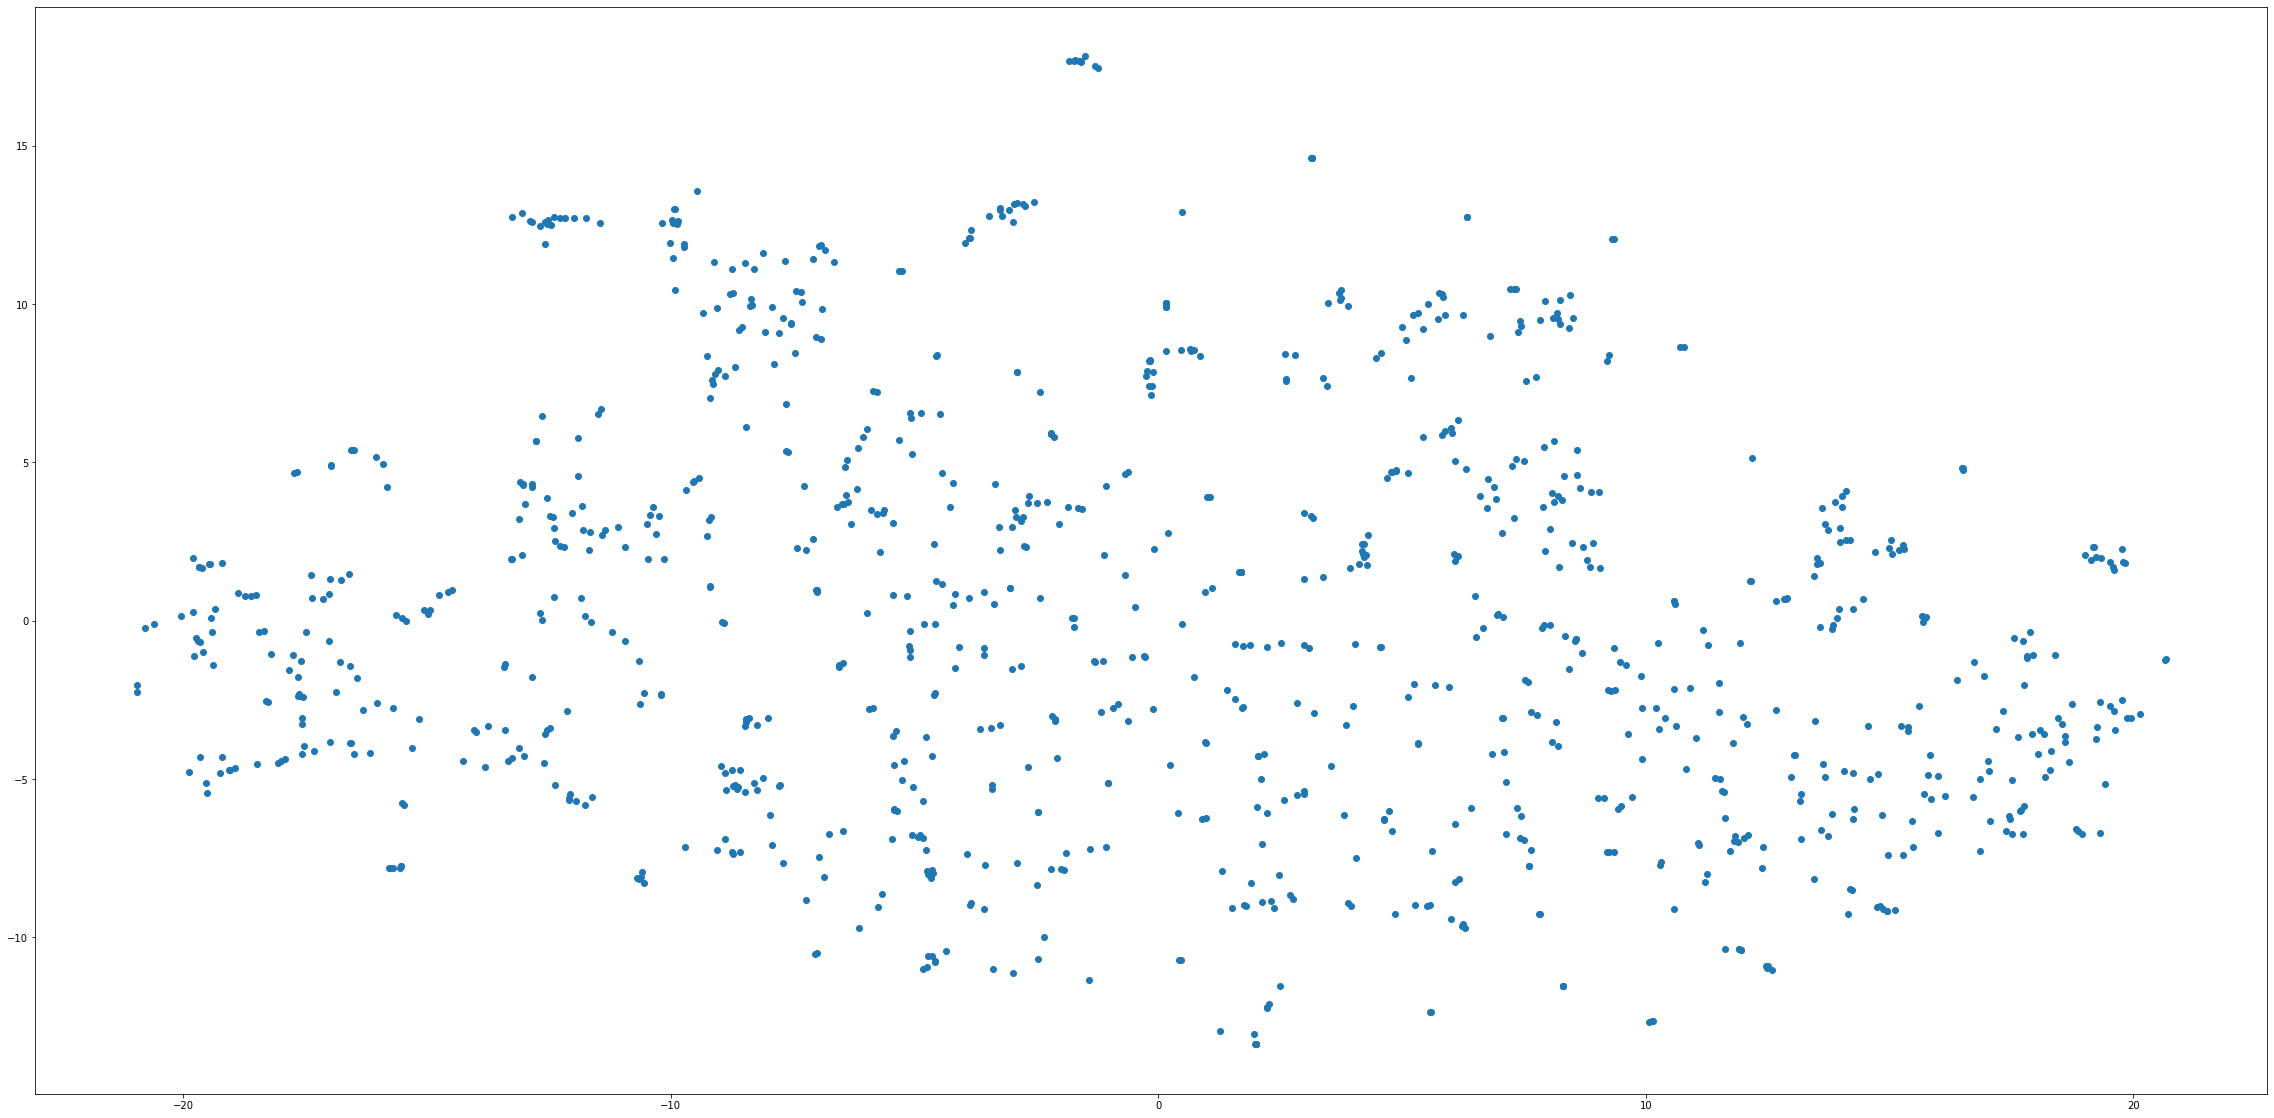

In [21]:
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_df["x"], tsne_df["y"])

#for word, pos in list(df.iterrows()):
#    ax.annotate(word, pos, fontsize=12, fontproperties=prop)
plt.show()

## 군집개수 결정 - 엘보우 함수

엘보우: 100%|██████████| 14/14 [00:02<00:00,  5.75it/s]


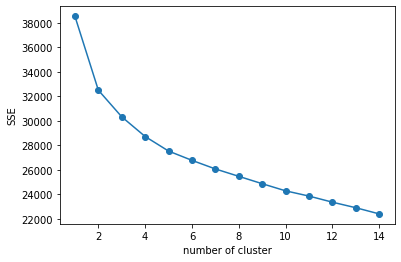

In [22]:
# 엘보우 함수로 군집 개수 결정

word_vectors = gender['문장벡터'].to_list() # 함수에 넣을 X값 지정
elbow(word_vectors)

## 군집개수 결정 - 실루엣 계수

In [23]:
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('silhouette')
    plt.show()

## KMeans

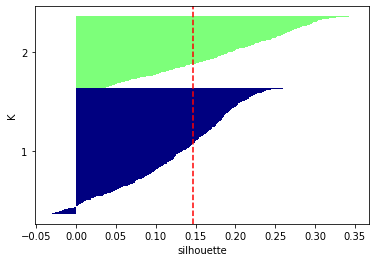

In [24]:
word_vectors = gender['문장벡터'].to_list()
k= 2

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

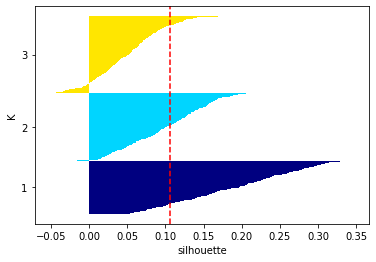

In [25]:
word_vectors = gender['문장벡터'].to_list()
k= 3

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

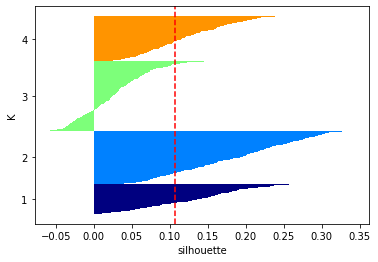

In [26]:
word_vectors = gender['문장벡터'].to_list()
k= 4

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

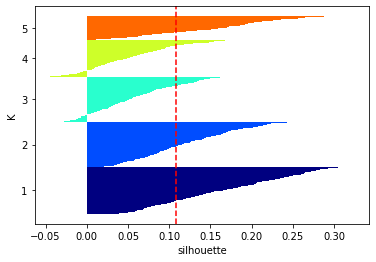

In [27]:
word_vectors = gender['문장벡터'].to_list()
k= 5

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

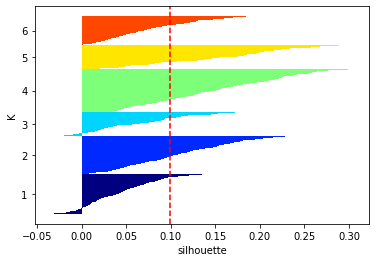

In [29]:
word_vectors = gender['문장벡터'].to_list()
k= 6

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

## KMeans 수행

In [30]:
# K means 수행 
word_vectors = gender['문장벡터'].to_list()
num_clusters = 6

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
gender['category'] = idx

In [31]:
gender['category'].value_counts()

0    222
5    199
4    199
3    154
2    139
1    131
Name: category, dtype: int64

In [32]:
from sklearn.manifold import TSNE

X = gender['문장벡터'].to_list()
y = gender['category'].to_list()

import os.path
import pickle

tsne_filepath = 'tsne3000.pkl'

tsne = TSNE(random_state=42)
tsne_points = tsne.fit_transform(X)

'''
# File Cache
if not os.path.exists(tsne_filepath):
    tsne = TSNE(random_state=42)
    tsne_points = tsne.fit_transform(X)
    with open(tsne_filepath, 'wb+') as f:
        pickle.dump(tsne_points, f)
else: # Cache Hits!
    with open(tsne_filepath, 'rb') as f:
        tsne_points = pickle.load(f)
'''

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = gender['의안번호'].to_list()
tsne_df['BillName'] = gender['의안명'].to_list()
tsne_df['cluster_no'] = y

In [33]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [34]:
# 색 정해주기

colors = brewer["Spectral"][len(tsne_df['cluster_no'].unique())]
colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}
colors = [colormap[x] for x in tsne_df['cluster_no']]
tsne_df['color'] = colors

In [35]:
# Bokeh가 인식하는 DataSource 객체 만들어주기
plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)
tsne_plot = figure(
    title='Bills about gender',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [36]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)


## 군집별 핵심단어 추출

In [69]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


2020-09-26 23:35:28,629 : INFO : Generating new fontManager, this may take some time...
2020-09-26 23:35:29,251 : INFO : Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
2020-09-26 23:35:29,299 : INFO : Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)
2020-09-26 23:35:29,498 : INFO : Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str


In [70]:
gender_g1 = gender[gender['category'] == 0]
gender_g2 = gender[gender['category'] == 1]
gender_g3 = gender[gender['category'] == 2]
gender_g4 = gender[gender['category'] == 3]
gender_g5 = gender[gender['category'] == 4]
gender_g6 = gender[gender['category'] == 5]
# gender_g7 = gender[gender['category'] == 6]

In [71]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
            
gender_g1_tokens = total_tokens(gender_g1['tokens'])
gender_g2_tokens = total_tokens(gender_g2['tokens'])
gender_g3_tokens = total_tokens(gender_g3['tokens'])
gender_g4_tokens = total_tokens(gender_g4['tokens'])
gender_g5_tokens = total_tokens(gender_g5['tokens'])
gender_g6_tokens = total_tokens(gender_g6['tokens'])

In [72]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고']
gender_g1_tokens = [each_word for each_word in gender_g1_tokens if each_word not in stopwords]
gender_g2_tokens = [each_word for each_word in gender_g2_tokens if each_word not in stopwords]
gender_g3_tokens = [each_word for each_word in gender_g3_tokens if each_word not in stopwords]
gender_g4_tokens = [each_word for each_word in gender_g4_tokens if each_word not in stopwords]
gender_g5_tokens = [each_word for each_word in gender_g5_tokens if each_word not in stopwords]
gender_g6_tokens = [each_word for each_word in gender_g6_tokens if each_word not in stopwords]

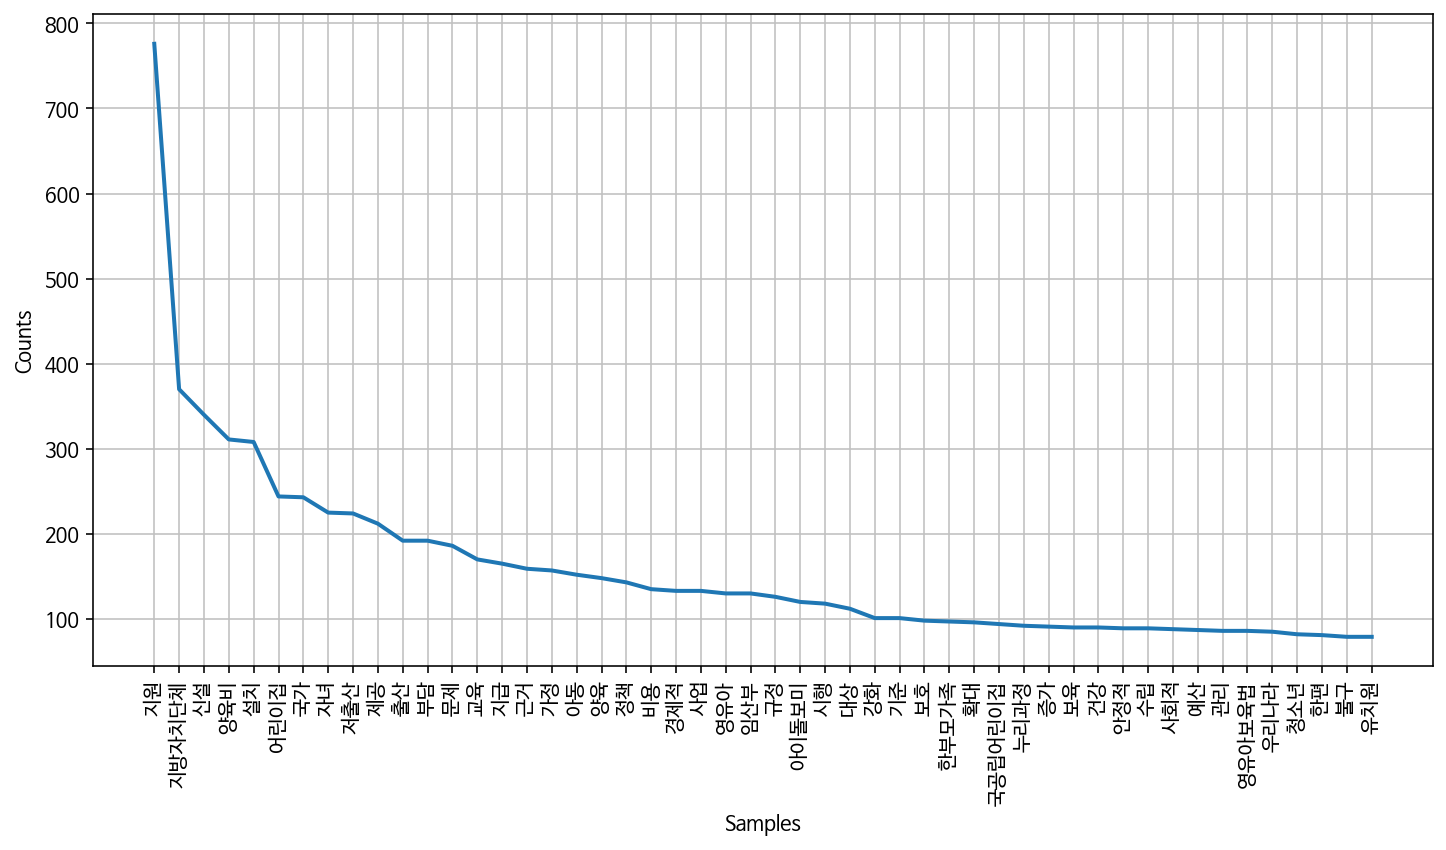

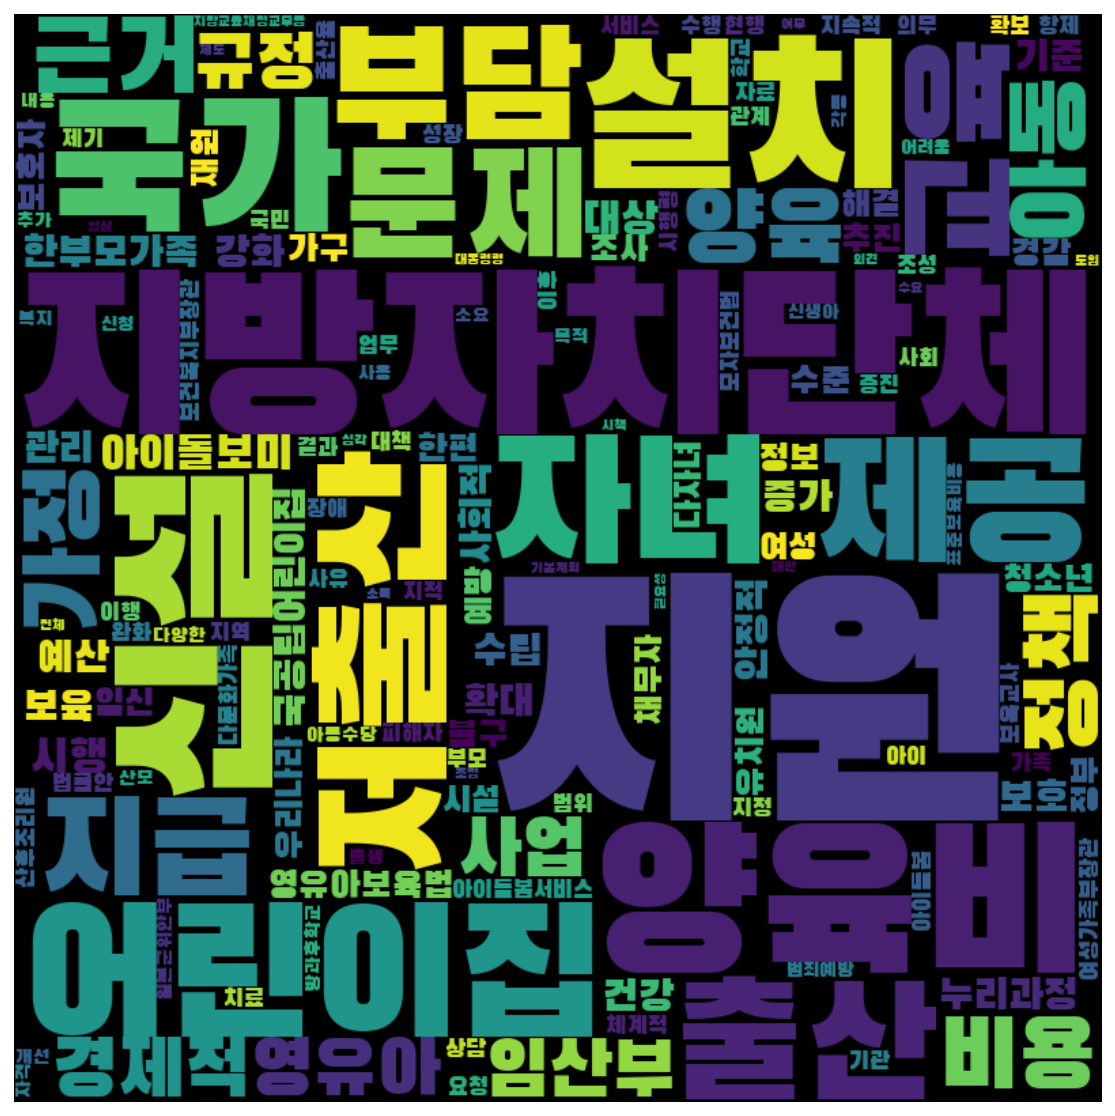

In [73]:
frewords_vis(gender_g1_tokens)
wordcloud_vis(gender_g1_tokens)

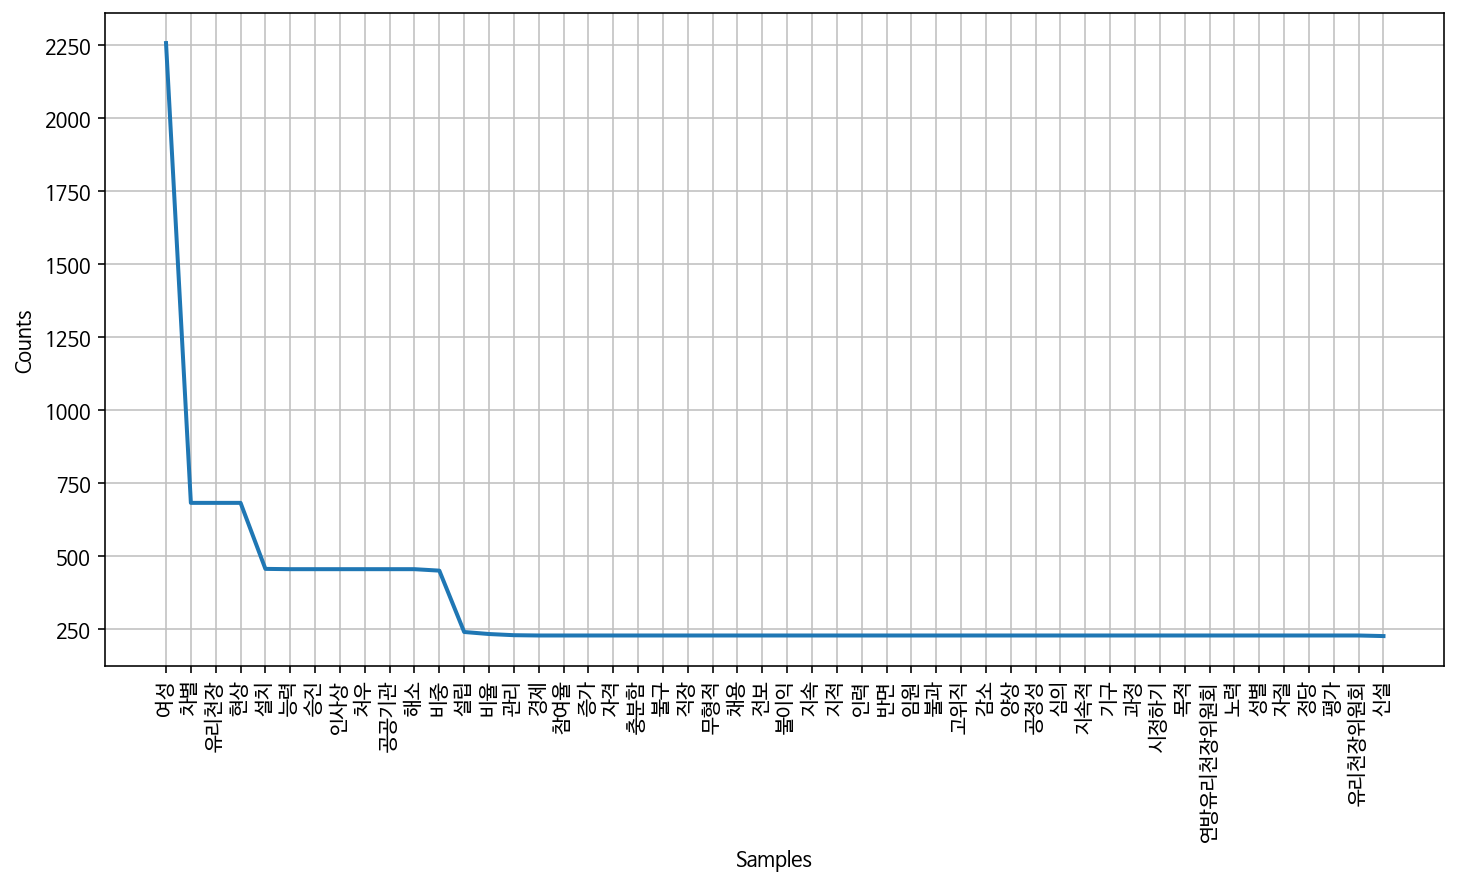

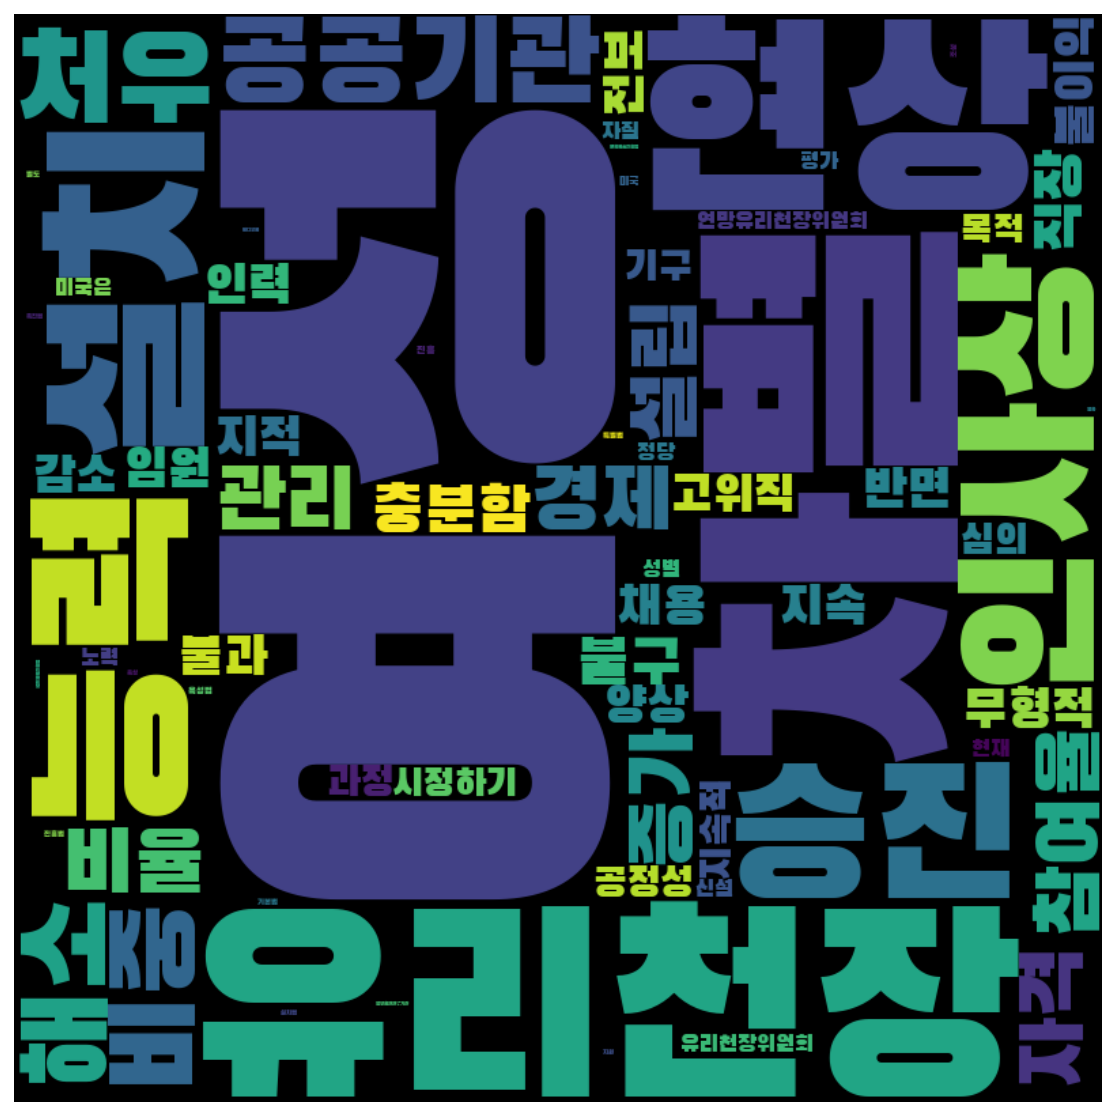

In [74]:
frewords_vis(gender_g2_tokens)
wordcloud_vis(gender_g2_tokens)

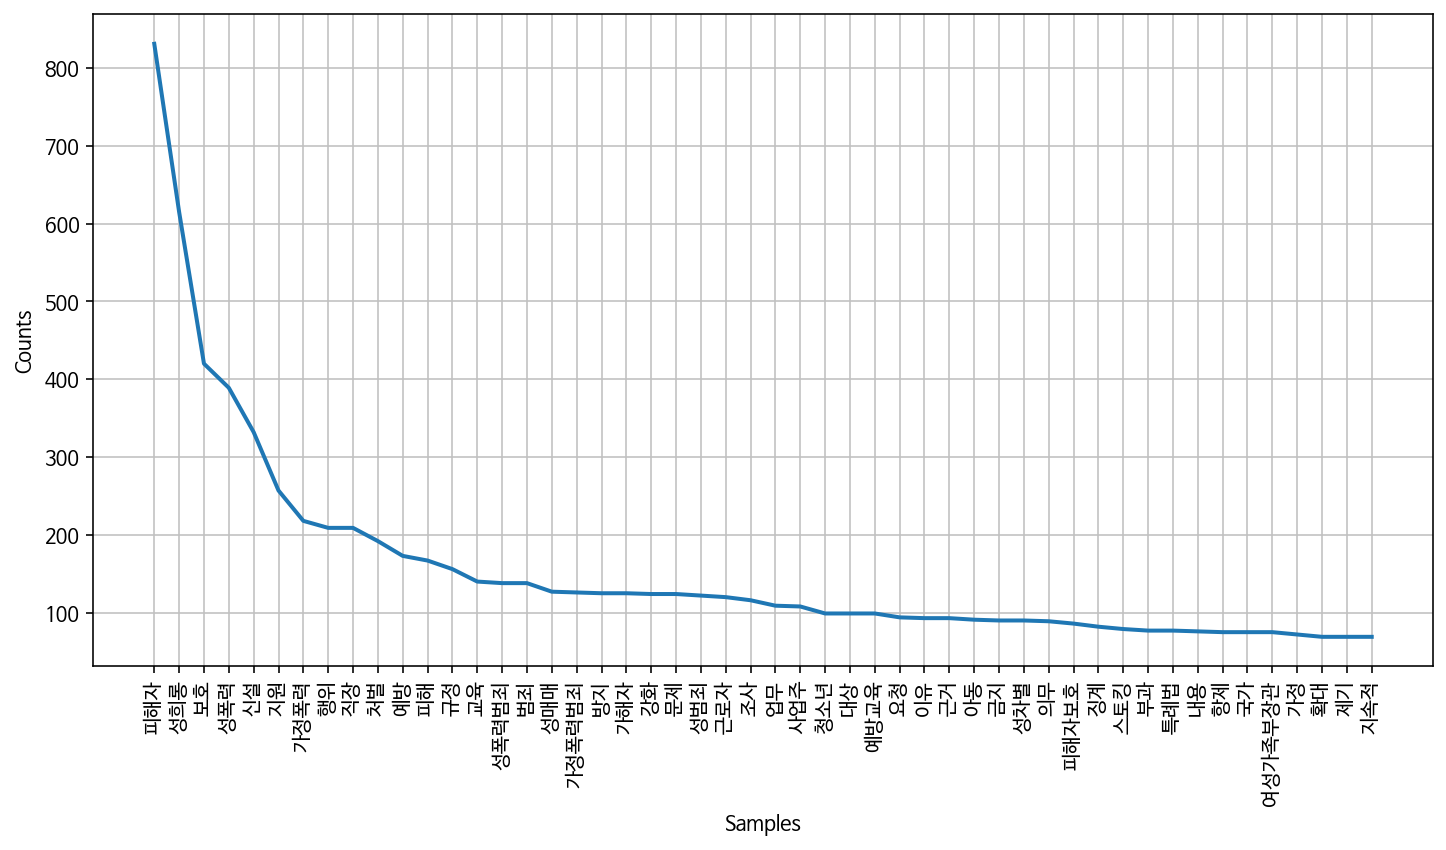

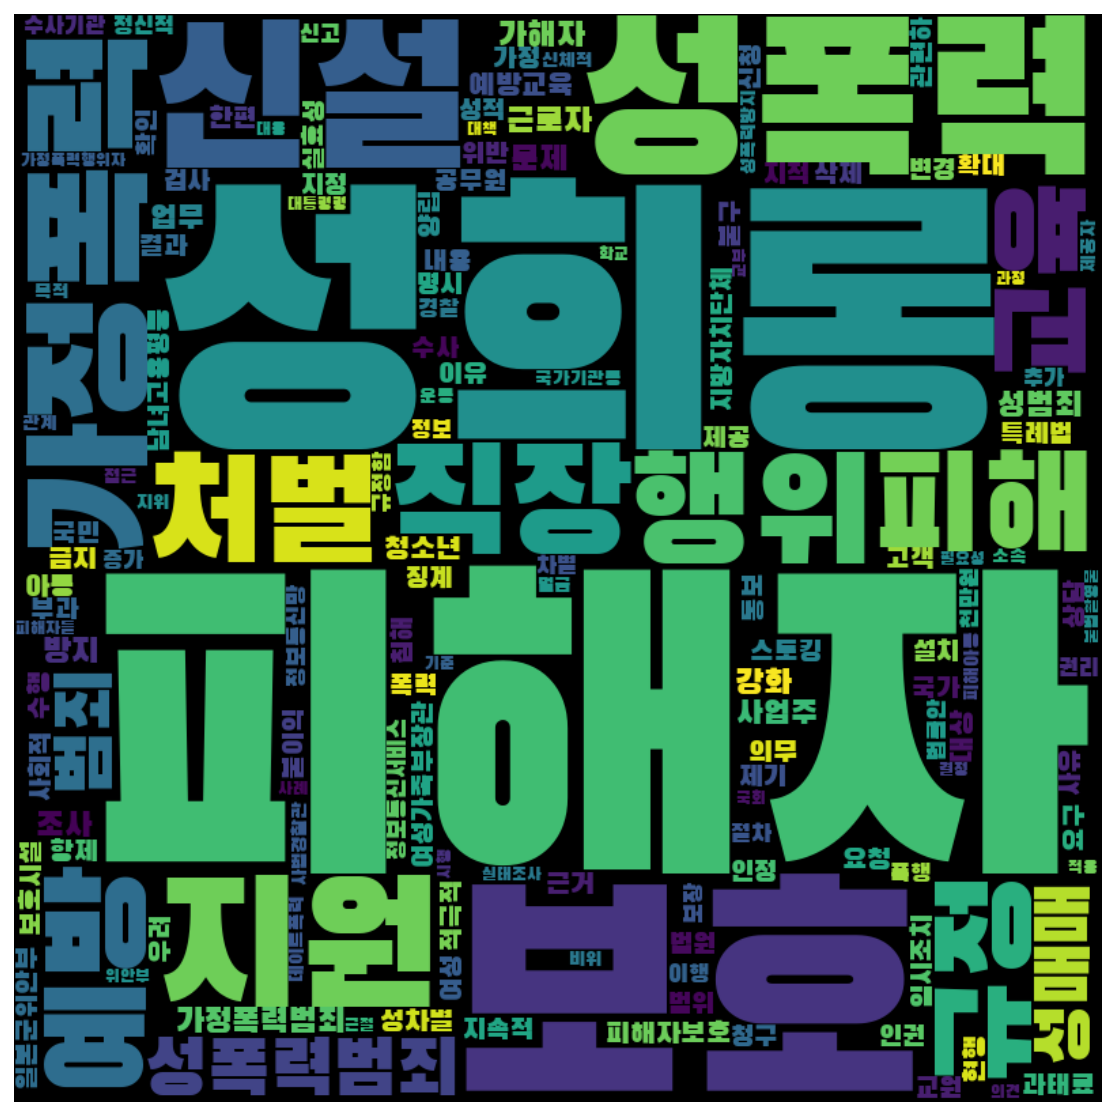

In [75]:
frewords_vis(gender_g3_tokens)
wordcloud_vis(gender_g3_tokens)

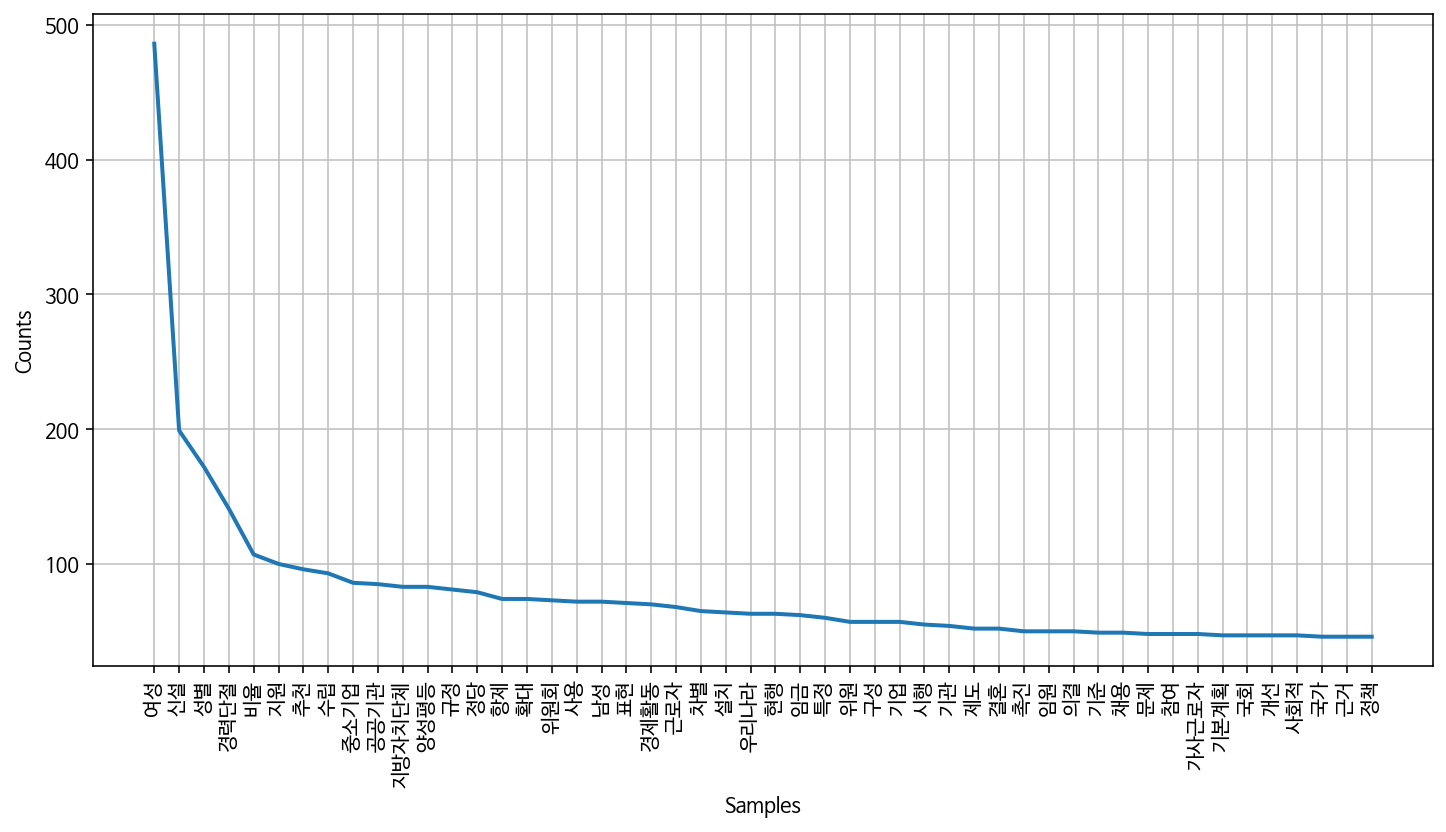

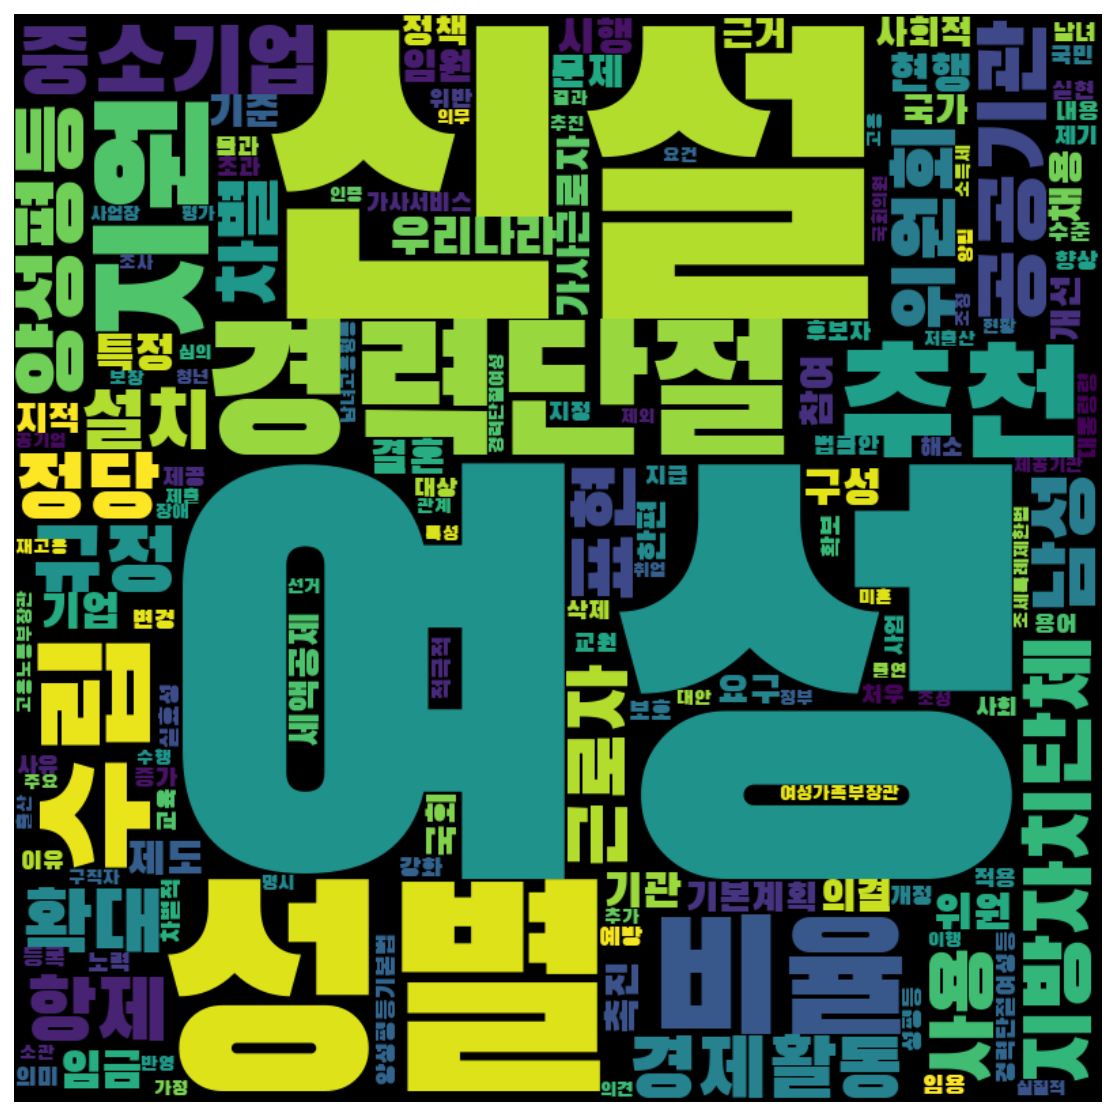

In [76]:
frewords_vis(gender_g4_tokens)
wordcloud_vis(gender_g4_tokens)

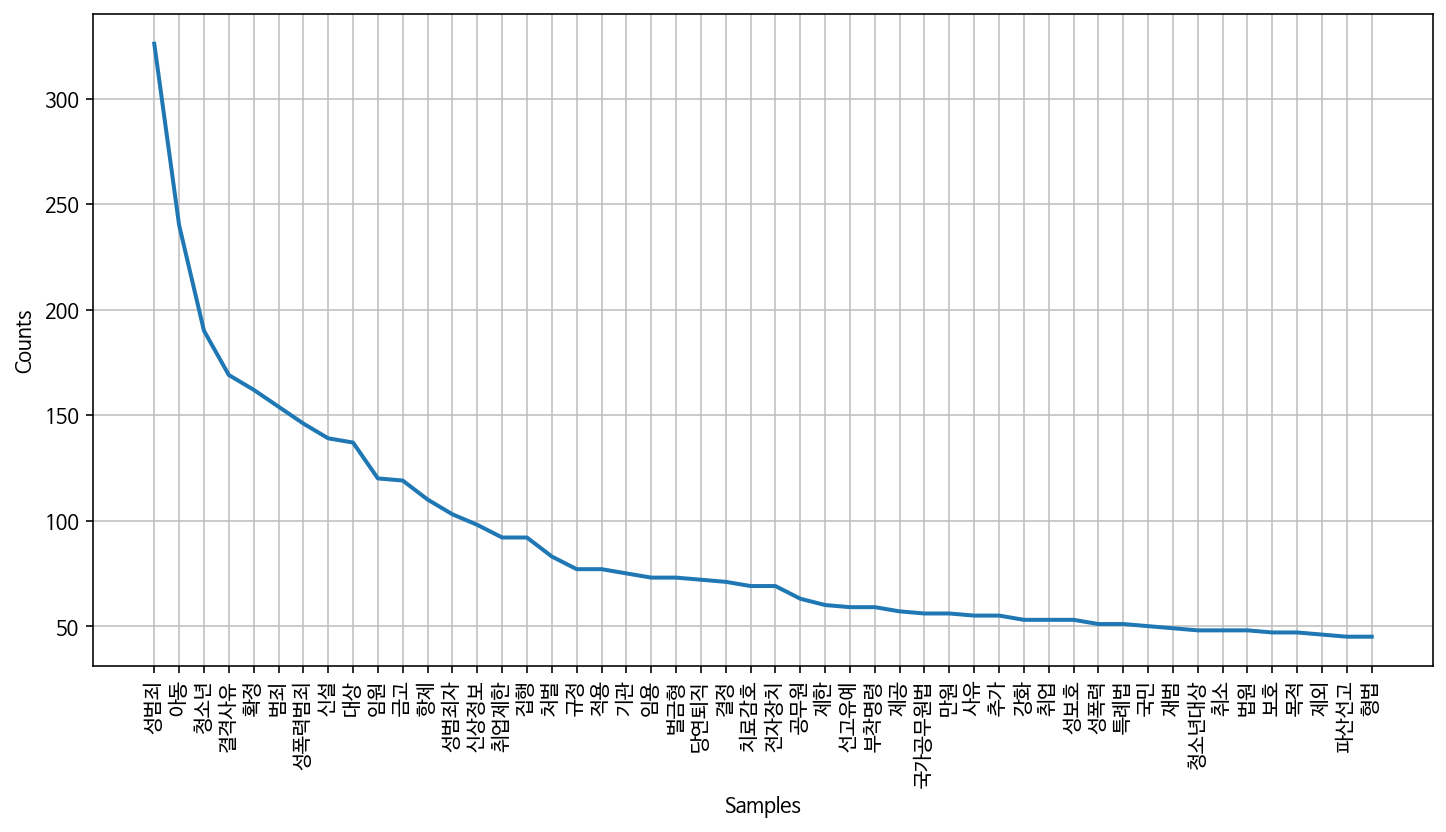

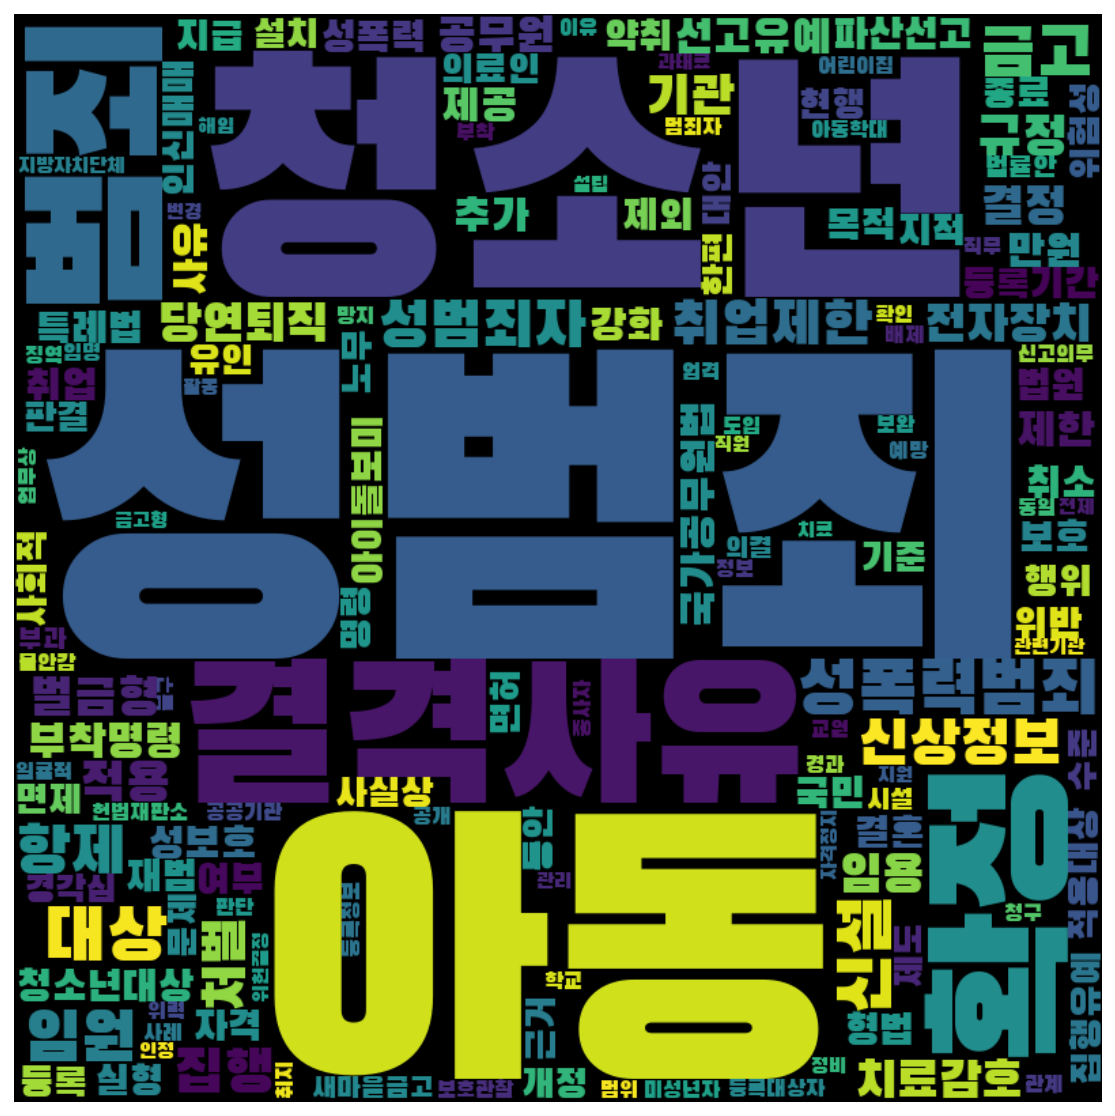

In [77]:
frewords_vis(gender_g5_tokens)
wordcloud_vis(gender_g5_tokens)

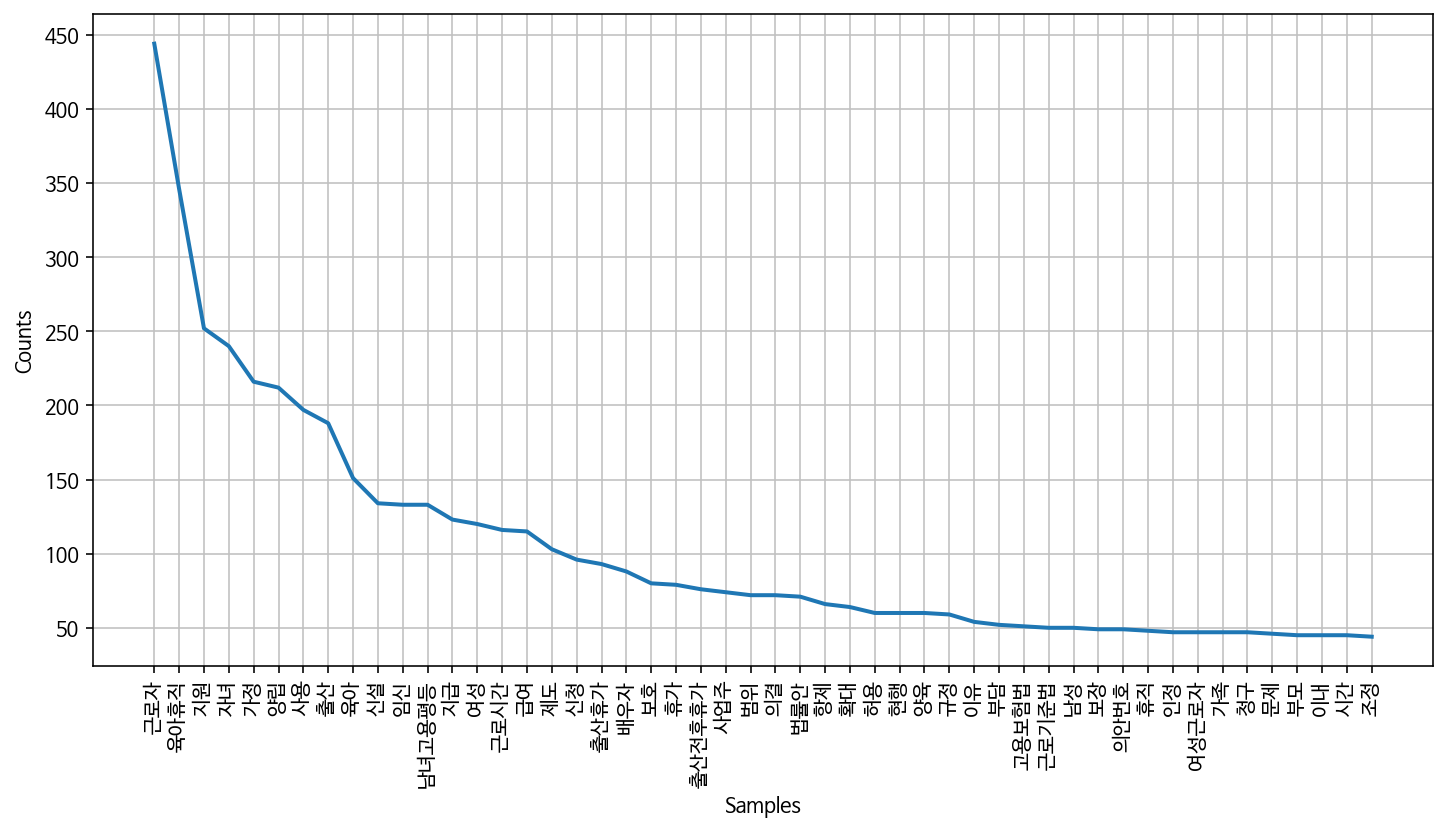

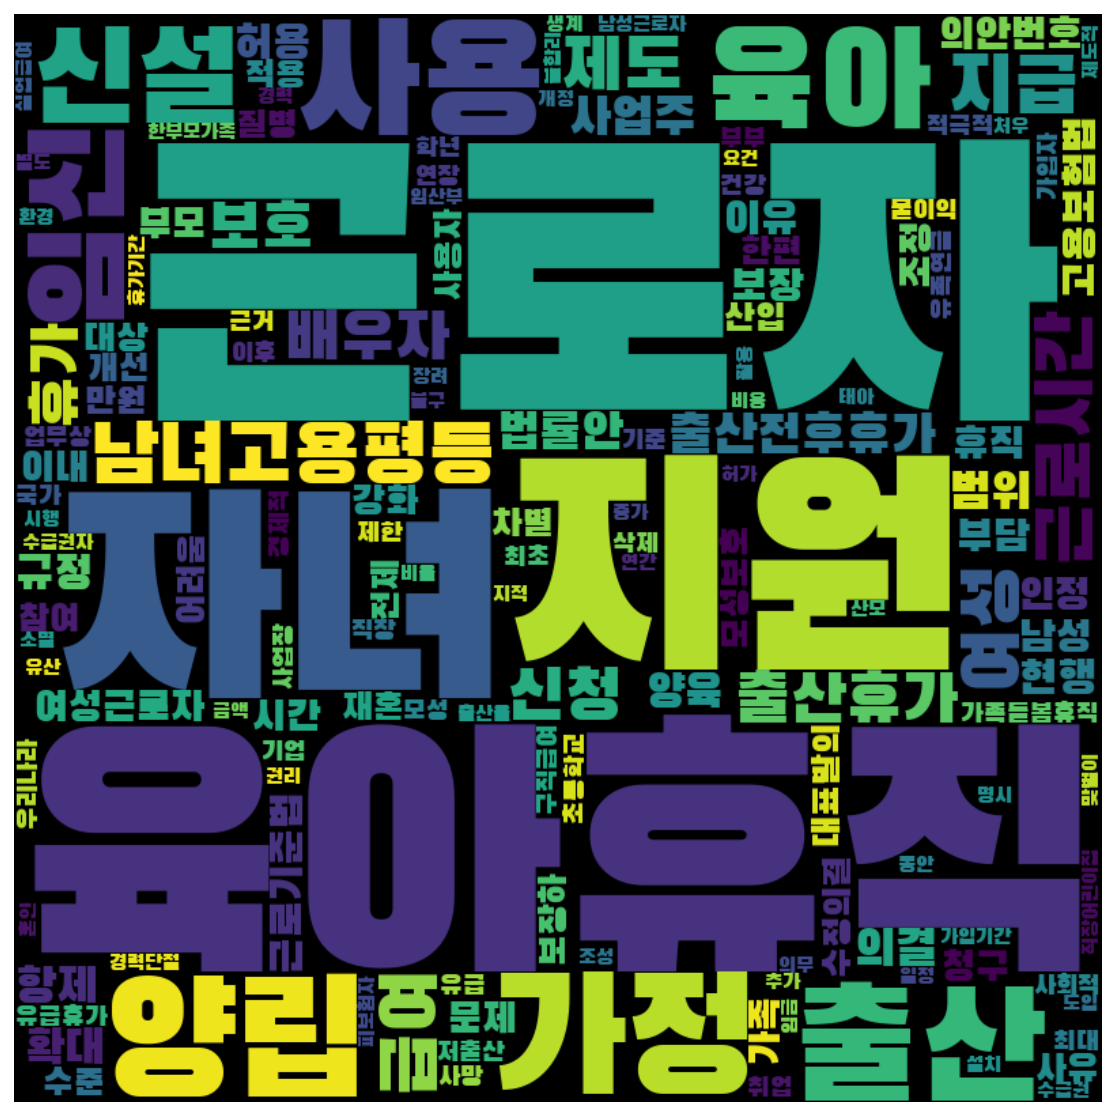

In [78]:
frewords_vis(gender_g6_tokens)
wordcloud_vis(gender_g6_tokens)